In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpy as np
import pandas as pd
import seaborn as sns
from jax import random
from numpyro import diagnostics, infer
from sklearn import datasets
from sklearn import linear_model


np.random.seed(12345)
rng_key = random.PRNGKey(0)

numpyro.set_host_device_count(4)

# Data

In [2]:
x, y = datasets.load_diabetes(return_X_y=True)
y = y[:, None]

x.shape, y.shape

((442, 10), (442, 1))

# Scikit-learn

In [3]:
lasso_sl = linear_model.LassoCV(cv=3, random_state=0).fit(x, y.ravel())

# Numpyro

In [17]:
def lasso_model(x, y=None):
    _, p = x.shape
    lmbda_2 = numpyro.sample("lmbda_2", dist.Gamma(1, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    u = numpyro.sample("u", dist.Exponential(lmbda_2 / 2 * jnp.ones(p)))
    u_0 = numpyro.sample("u_0", dist.Exponential(lmbda_2 / 2))
    w = numpyro.sample("w", dist.Normal(jnp.zeros(p), sigma * u ** 0.5))
    bias = numpyro.sample("bias", dist.Normal(0, sigma * u_0 ** 0.5))
    numpyro.sample("y", dist.Normal((x * w).sum(-1) + bias, sigma), obs=y)

In [18]:
x = jnp.array(x)
y = jnp.array(y)

In [19]:
rng_key, rng_key_linear = random.split(rng_key)

kernel = infer.NUTS(lasso_model)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=500, num_chains=1)
mcmc.run(rng_key_linear, x, y)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s, 31 steps of size 1.59e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      bias    152.13      0.18    152.13    151.85    152.42    556.76      1.01
   lmbda_2      3.84      1.73      3.70      1.00      6.16    410.22      1.00
     sigma     77.01      0.13     77.01     76.80     77.22    591.85      1.00
      u[0]      0.36      0.54      0.14      0.00      1.01    464.52      1.00
      u[1]      0.36      0.51      0.16      0.00      0.95    434.46      1.01
      u[2]      0.35      0.54      0.14      0.00      0.92    535.20      1.00
      u[3]      0.35      0.60      0.12      0.00      0.92    570.99      1.00
      u[4]      0.42      0.59      0.22      0.00      1.00    456.97      1.00
      u[5]      0.43      0.70      0.19      0.00      1.09    426.18      1.00
      u[6]      0.35      0.44      0.19      0.00      0.87    599.31      1.00
      u[7]      0.39      0.61      0.17      0.00      1.08    420.63      1.00
      u[8]      0.38      0

In [20]:
rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(lasso_model, posterior_samples=posterior_samples)
posterior_predictive = predictive(rng_key_posterior, x)

numpyro_data = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

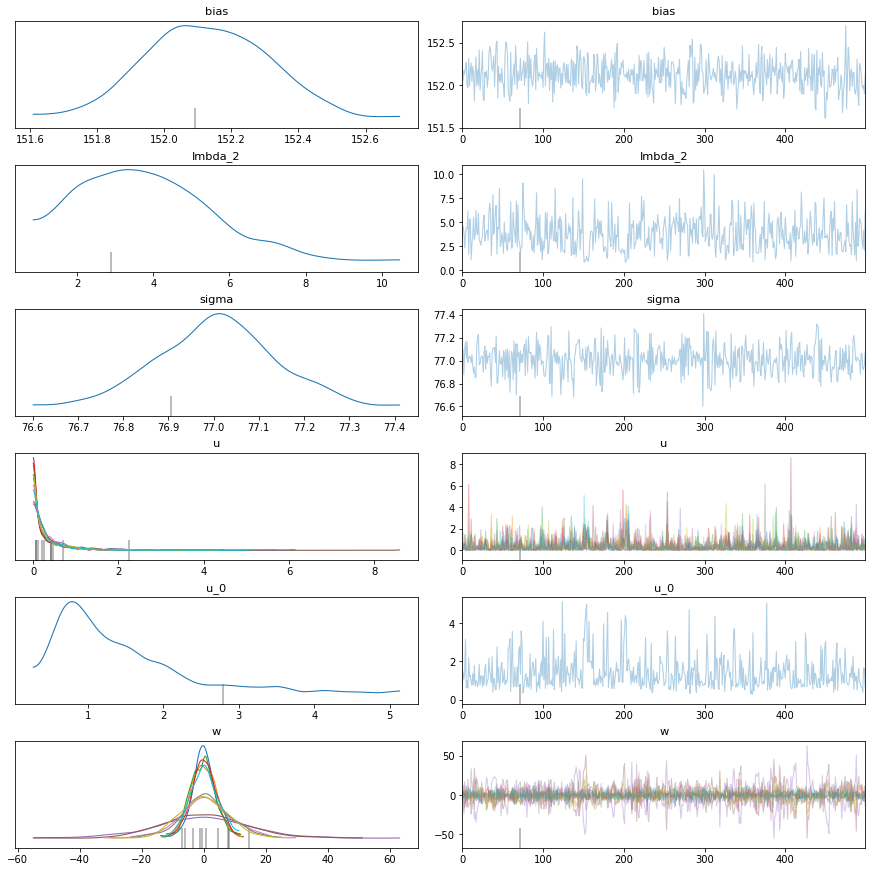

In [21]:
az.plot_trace(numpyro_data)
plt.show()

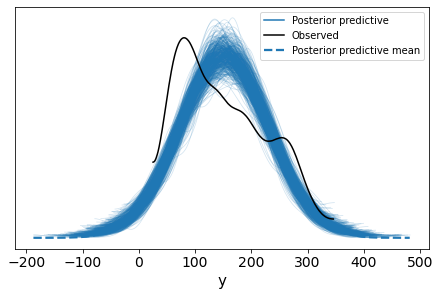

In [22]:
az.plot_ppc(numpyro_data)
plt.legend(loc="upper right")
plt.show()

# Comparison

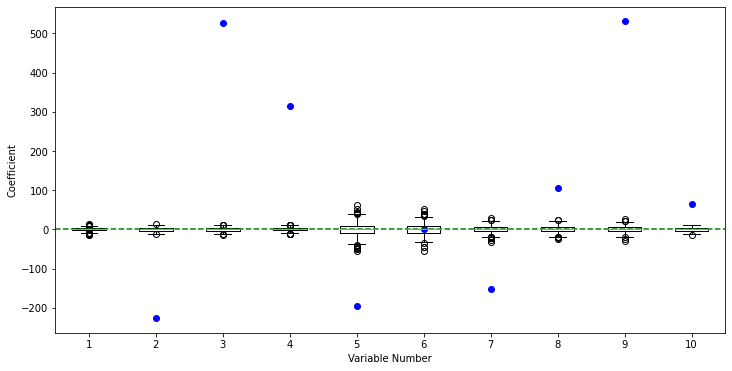

In [23]:
plt.figure(figsize=(12, 6))
plt.boxplot(posterior_samples["w"].T)
plt.scatter(np.arange(1, 11, 1), lasso_sl.coef_, color="b")
plt.axhline(0, linestyle="--", color="g")
plt.xlabel("Variable Number")
plt.ylabel("Coefficient")
plt.show()